In [1]:
from torchvision import datasets
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt


c:\Users\Ilir\anaconda3\envs\gen-ai\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] Die angegebene Prozedur wurde nicht gefunden'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
def convert_mnist_to_vectors(data):
    #we already had this method in task 2
    mnist_vectors = []
    labels = []
    images = data.data
    labels = data.targets
    mnist_vectors = images.view(images.shape[0], -1)
    train_images = mnist_vectors.float() / 255.0
    mnist_vectors =  (2 * train_images) - 1

    return mnist_vectors, labels

In [3]:
def do_pca(data):
    #we already had this method in task 2
    cov = np.cov(data.T)
    eigVals, eigVec = np.linalg.eig(cov)
    sorted_index = eigVals.argsort()[::-1]
    eigVals = eigVals[sorted_index]
    sorted_eigenVectors = eigVec[:, sorted_index]
    return sorted_eigenVectors.astype(np.float32).T

In [4]:
def plot_projection(sorted_eigenVectors,activations, labels):

    #we already had this method in task 2
    two_pcs = sorted_eigenVectors[:2]
    new_coordinates = np.matmul(activations, two_pcs.T)

    plt.figure(figsize=(10,8))
    scatter = plt.scatter(new_coordinates[:,0],new_coordinates[:,1],c=labels,cmap='tab10',alpha=0.6)
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.title('Projection of ReLU activation features on first two PCs')
    plt.colorbar(scatter)
    plt.show


In [5]:
# The first thing to do is specify our model. The multilayer perceptron does a matrix
# multiplication of its internal weights with the inputs and adds a bias in
# each layer. After that it activates the resulting vector.
# This can be done using the `Linear` layer. 
# Our model itself will be implemented in an object-oriented manner. You can
# find a skeleton implementation below. Please fill in the blanks marked with
# `# Your code here`. As we want to use mnist vectors as input data, make sure
# to pass the correct dimensions to the `Linear` module. 

# As our multilayer perceptron is a pytorch module, it has to inherit from the base
# `nn.Module`.  All pytorch modules expect at least a `forward` method, which
# defines what happens, when you call the instance of such a module on some
# data.


class MultilayerPerceptron(nn.Module):
    
    def __init__(self, size_hidden=100, size_out=10):
        super().__init__()
        
        self.fc1 = nn.Linear(784, size_hidden)

        self.fc2 = nn.Linear(size_hidden, size_hidden)
        self.fc3 = nn.Linear(size_hidden, size_hidden)
        self.fc4 = nn.Linear(size_hidden, size_hidden)

        self.out_layer = nn.Linear(size_hidden, size_out)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)

        # Apply the same pattern for the subsequent hidden layers
        out = self.fc2(out)
        out = self.relu(out)
        
        out = self.fc3(out)
        out = self.relu(out)
        
        out = self.fc4(out)
        out = self.relu(out)

        # Output layer, no ReLU activation here since we might apply softmax later during loss computation
        out = self.out_layer(out)

        return out


# Pytorch modules keep track of all model parameters internally. Those will be
# e.g. the matrix and bias of the `Linear` operation we just implemented.

# To be able to feed the mnist vectors to out MultilayerPerceptron we first have to
# convert them to `torch.Tensor`s. To not have to do this everytime we want to
# do an operation on those vectors you can find a `torch.Dataset` version of
# the mnist vectors below. All it does is a simple casting operation.


class MnistVectors(torch.utils.data.Dataset):
    '''A Pytorch Dataset, which does the same data preparation as was done in
    the PCA exercise.'''

    def __init__(self, split='train'):
        super().__init__()
        
        mnist = datasets.MNIST('../data',
                               train=split=='train',
                               download=True)

        ########################
        #### Your Code here ####
        self.mnist_vectors, self.labels = convert_mnist_to_vectors(data=mnist)
        ########################

            
    def __getitem__(self, idx):
        '''Implements the ``[idx]`` method. Here we convert the numpy data to
        torch tensors.
        '''

        mvec = torch.tensor(self.mnist_vectors[idx]).float()
        label = torch.tensor(self.labels[idx]).long()

        return mvec, label
    
    def __len__(self):
        return len(self.labels)
    

    # The following two functions are needed to track the progress of the training.
# One transforms the output of the MultilayerPerceptron into a scalar class label, the 
# other uses that label to calculate the batch accuracy.

def batch_accuracy(prediction, label):
    right_predictions = (prediction == label).float()  # Convert boolean tensor to float to enable mean calculation
    acc = right_predictions.mean()
    return acc

def class_label(prediction):
    class_label = torch.argmax(prediction, dim=1)#take highest probability prediction as class label
    return class_label

def train(use_gpu=False): # if torch.cuda.is_available(), use gpu to speed up training
    
    # Here we instantiate our model. The weights of the model are automatically
    # initialized by pytorch
    P = MultilayerPerceptron()
    epochs = 5
    TrainData = MnistVectors()
    TestData = MnistVectors('test')
    # Dataloaders allow us to load the data in batches. This allows us a better
    # estimate of the parameter updates when doing backprop.
    # We need two Dataloaders so that we can train on the train data split
    # and evaluate on the test datasplit.
    Dl = DataLoader(TrainData, batch_size=16, shuffle=True)
    testDl = DataLoader(TestData, batch_size=16, shuffle=False)
    
    # Use the Adam optimizer with learning rate 1e-4 and otherwise default
    # values
    optimizer = optim.Adam(P.parameters(), lr=1e-4)

    # Use the Cross Entropy loss from pytorch. Make sure your MultilayerPerceptron does
    
    # not use any activation function on the output layer! (Do you know why?)
    criterion = nn.CrossEntropyLoss()
    
    if use_gpu:
        P.cuda()
        criterion.cuda()

    layers = ['fc1', 'fc2', 'fc3', 'fc4'] # linear layer names
    activations = [ [], [], [], [] ] # data structure to save the activation features
    def get_activation(layer_number):
        def hook(module,input,output):
            linear_output=output.detach()# attach hook after each linear layer output
            relu_output=torch.relu(linear_output).cpu() # take linear layer output and compute its relu
            activations[layer_number].append(relu_output) # save the relu features in the data structure
        return hook    
    
    for epoch in tqdm(range(epochs), desc='Epoch'):
        for step, [example, label] in enumerate(tqdm(Dl, desc='Batch')):
            if use_gpu:
                example = example.cuda()
                label = label.cuda()
            
            # The optimizer knows about all model parameters. These in turn
            # store their own gradients. When calling loss.backward() the newly
            # computed gradients are added on top of the existing ones. Thus
            # at before calculating new gradients we need to clear the old ones
            # using ther zero_grad() method.
            optimizer.zero_grad()
            
            prediction = P(example)
            
            loss = criterion(prediction, label)
            
            # Here pytorch applies backpropagation for us completely
            # automatically!!! That is quite awesome!
            loss.backward()

            # The step method now adds the gradients onto the model parameters
            # as specified by the optimizer and the learning rate.
            optimizer.step()
            
            # To keep track of what is happening print some outputs from time
            # to time.
            if (step % 375) == 0:
                # Your code here
                acc = batch_accuracy(class_label(prediction), label)
                tqdm.write('Batch Accuracy: {}%, Loss: {}'.format(acc, loss))
                
        # Now validate on the whole test set
        test_accuracies = []
        test_labels = []
        if(epoch == epochs-1): # do the activation feature extraction only for the last epoch, no need for all
            for index, layer_name in enumerate(layers):
                getattr(P,layer_name).register_forward_hook(get_activation(index)) # register the hook to the linear layers of our MLP model


        for idx, [test_ex, test_l] in enumerate(tqdm(testDl, desc='Test')):
            if use_gpu:
                test_ex = test_ex.cuda()
                test_l = test_l.cuda()

            #########################
            #### Your Code here  ####
            #########################

            test_labels.extend(test_l.cpu().tolist())
            P.eval()

            # Using your batch_accuracy function, also print the mean accuracy
            # over the whole test split of the data.
            with torch.no_grad():
                prediction = P(test_ex)
                class_pred = class_label(prediction)
                acc = batch_accuracy(class_pred,test_l)
                test_accuracies.append(acc)

        test_accuracies = torch.tensor(test_accuracies)
        print('Validation Accuracy: {}%'.format(test_accuracies.mean().item()))

        # Now let's write out a checkpoint of the model, so that we can
        # reuse it:
        torch.save(P.state_dict(), 'perceptron_{}.ckpt'.format(step))

        # If you need to load the checkpoint instanciate your model and the
        # load the state dict from a checkpoint:
        # P = MultilayerPerceptron()
        # P.load_state_dict(torch.load(perceptron_3750.ckpt))
        # Make sure to use the latest checkpoint by entering the right number.

        ######################################
        ###### Add code for task 4 here ######
        ######################################
    activations = np.array(activations)
    new_activations = activations.reshape(4,10000,100)#reshape the activation features to the shape given in the exercise
    print('Plots for the 4 ReLU layers: ')
    for index, activation_feature in enumerate(new_activations):
        eigenvecs = do_pca(np.array(activation_feature))
        plot_projection(eigenvecs, activation_feature, test_labels)




Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Batch:   0%|          | 0/3750 [00:00<?, ?it/s]

C:\Users\Ilir\AppData\Local\Temp\ipykernel_19220\3366880705.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mvec = torch.tensor(self.mnist_vectors[idx]).float()
C:\Users\Ilir\AppData\Local\Temp\ipykernel_19220\3366880705.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[idx]).long()


Batch Accuracy: 0.125%, Loss: 2.2922310829162598
Batch Accuracy: 0.75%, Loss: 0.8015817403793335
Batch Accuracy: 0.625%, Loss: 0.8852081298828125
Batch Accuracy: 0.8125%, Loss: 0.5131732225418091
Batch Accuracy: 0.875%, Loss: 0.35988903045654297
Batch Accuracy: 0.9375%, Loss: 0.5259806513786316
Batch Accuracy: 0.875%, Loss: 0.7920462489128113
Batch Accuracy: 0.75%, Loss: 0.948291003704071
Batch Accuracy: 0.875%, Loss: 0.5661073327064514
Batch Accuracy: 0.9375%, Loss: 0.2581541836261749


Test:   0%|          | 0/625 [00:00<?, ?it/s]

Validation Accuracy: 0.9004999995231628%


Batch:   0%|          | 0/3750 [00:00<?, ?it/s]

Batch Accuracy: 0.9375%, Loss: 0.24957497417926788
Batch Accuracy: 0.8125%, Loss: 0.48620519042015076
Batch Accuracy: 0.875%, Loss: 0.3121509253978729
Batch Accuracy: 0.9375%, Loss: 0.19696734845638275
Batch Accuracy: 0.8125%, Loss: 0.6799178123474121
Batch Accuracy: 1.0%, Loss: 0.10645811259746552
Batch Accuracy: 1.0%, Loss: 0.06700330972671509
Batch Accuracy: 1.0%, Loss: 0.04057521000504494
Batch Accuracy: 0.8125%, Loss: 1.2762259244918823
Batch Accuracy: 0.9375%, Loss: 0.4641435742378235


Test:   0%|          | 0/625 [00:00<?, ?it/s]

Validation Accuracy: 0.9279999732971191%


Batch:   0%|          | 0/3750 [00:00<?, ?it/s]

Batch Accuracy: 0.8125%, Loss: 0.5076194405555725
Batch Accuracy: 0.9375%, Loss: 0.23114874958992004
Batch Accuracy: 1.0%, Loss: 0.08661802858114243
Batch Accuracy: 0.875%, Loss: 0.4280295670032501
Batch Accuracy: 0.8125%, Loss: 0.6486178636550903
Batch Accuracy: 1.0%, Loss: 0.06765548139810562
Batch Accuracy: 0.875%, Loss: 0.1987960785627365
Batch Accuracy: 1.0%, Loss: 0.11957011371850967
Batch Accuracy: 0.9375%, Loss: 0.26612547039985657
Batch Accuracy: 0.9375%, Loss: 0.2007673978805542


Test:   0%|          | 0/625 [00:00<?, ?it/s]

Validation Accuracy: 0.9429000020027161%


Batch:   0%|          | 0/3750 [00:00<?, ?it/s]

Batch Accuracy: 0.9375%, Loss: 0.13368535041809082
Batch Accuracy: 1.0%, Loss: 0.08327934145927429
Batch Accuracy: 0.9375%, Loss: 0.15246054530143738
Batch Accuracy: 1.0%, Loss: 0.05448360741138458
Batch Accuracy: 0.9375%, Loss: 0.10993604362010956
Batch Accuracy: 0.9375%, Loss: 0.1480015367269516
Batch Accuracy: 1.0%, Loss: 0.055305492132902145
Batch Accuracy: 0.875%, Loss: 0.24534238874912262
Batch Accuracy: 0.875%, Loss: 0.28384923934936523
Batch Accuracy: 0.9375%, Loss: 0.12365929037332535


Test:   0%|          | 0/625 [00:00<?, ?it/s]

Validation Accuracy: 0.9513000249862671%


Batch:   0%|          | 0/3750 [00:00<?, ?it/s]

Batch Accuracy: 1.0%, Loss: 0.01793198473751545
Batch Accuracy: 0.9375%, Loss: 0.1458732932806015
Batch Accuracy: 1.0%, Loss: 0.04701591283082962
Batch Accuracy: 1.0%, Loss: 0.02153932861983776
Batch Accuracy: 1.0%, Loss: 0.09056280553340912
Batch Accuracy: 0.9375%, Loss: 0.1206371858716011
Batch Accuracy: 1.0%, Loss: 0.013990060426294804
Batch Accuracy: 1.0%, Loss: 0.04100107401609421
Batch Accuracy: 1.0%, Loss: 0.0554373562335968
Batch Accuracy: 0.9375%, Loss: 0.1453401893377304


Test:   0%|          | 0/625 [00:00<?, ?it/s]

Validation Accuracy: 0.9570000171661377%
Plots for the 4 ReLU layers: 


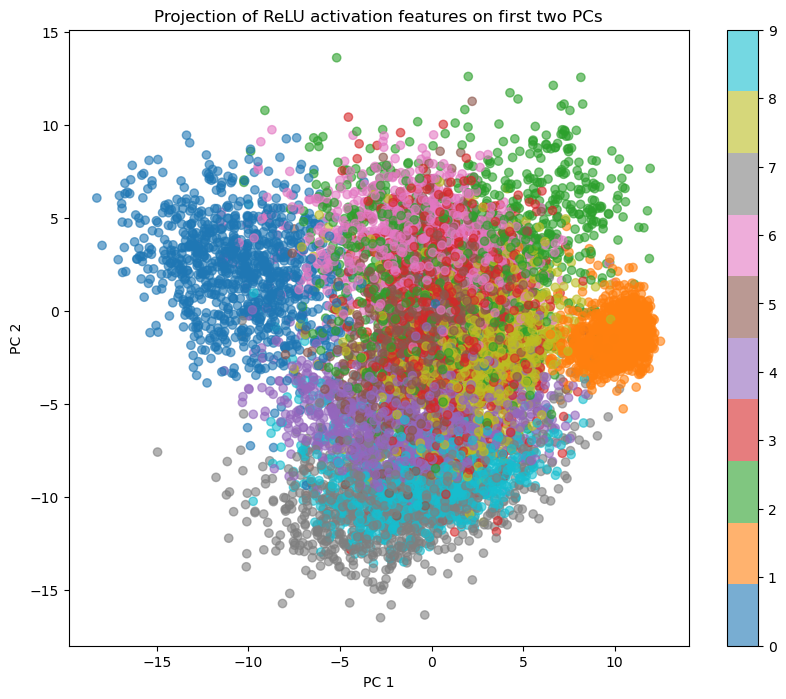

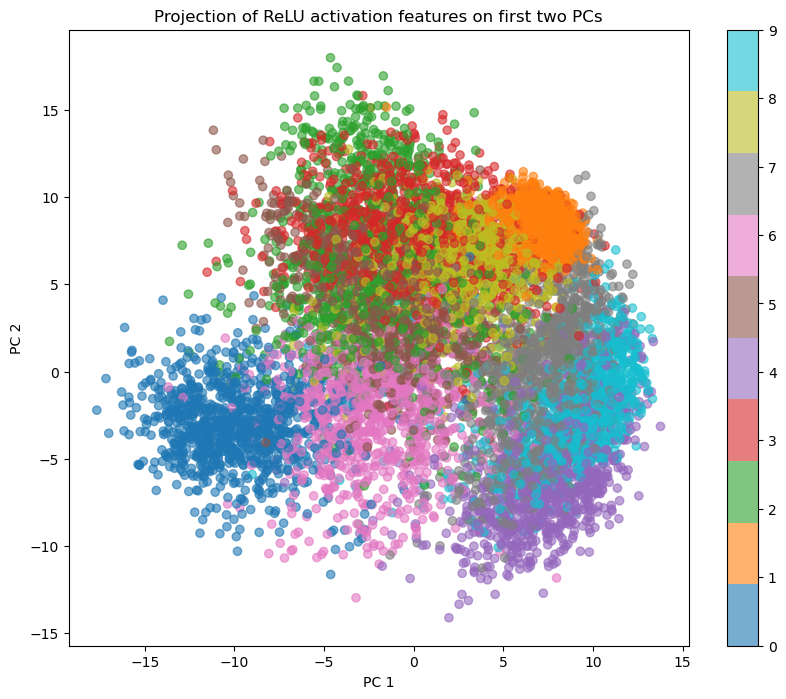

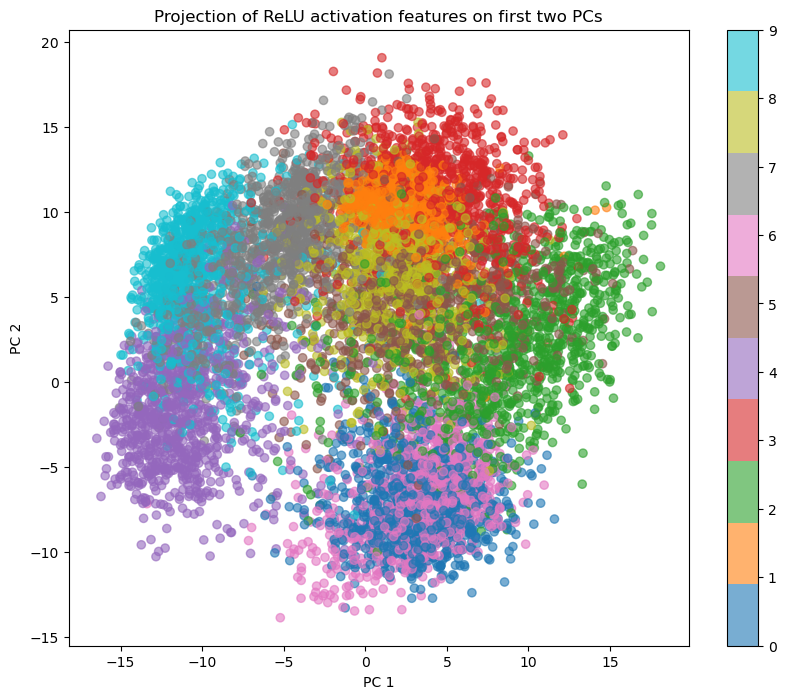

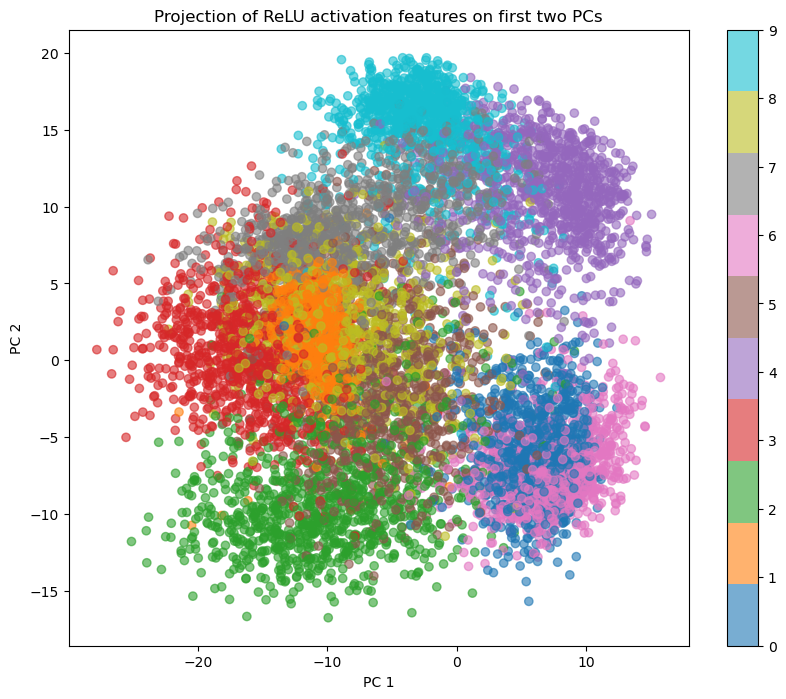

In [6]:
activations = train(use_gpu=True if torch.cuda.is_available() else False)


# Comments regarding 4.3
It depends which plot we are looking at. We can observe that some classes are better separable from each other compared to some others. 
In the last plot the 0 and 6 have overlaps.
2, 4 and 9 have somewhat clear margins and are good separated.
5 is scattered a lot and doesn't have clear margins.
8 is not clearly separable.

# Comments regarding 4.4
The MLP has performed well on the digit classification task where we can see the high validation accuracy. What has changed in the plots between task 2 and now with the ReLU activation feature plots is that the data has become better separable and such enabled a better classification of the digits. So the MLP may be suitable for solving the digit classification problem, BUT depending on the task my achieved 95% accuracy may not be enough and you would need >=99%. So it depends on the task. 